# Observe reconstruction fidelity

In [86]:
import os
import random
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [2]:
path = "/Users/M283455/VAE_prject/scripts/"
sys.path.insert(0, path)

In [3]:
import VAE_tybalt
from VAE_tybalt import VAE

In [4]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [5]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

Load data

In [6]:
tcga_tybalt_file_location = "../../VAE_prject_data/raw/rnaseq_df_test.csv"
rnaseq_df = pd.read_csv(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [7]:
rnaseq_df.head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.000000,0.676411,0.538535,0.829060,0.371617,0.076709,0.493035,0.495491,0.000000,0.000000,...,0.641401,0.258891,0.520563,0.400908,0.437579,0.560402,0.483713,0.054940,0.333915,0.313550
1,0.000000,0.601335,0.791538,0.580519,0.711329,0.771928,0.557838,0.656916,0.000000,0.000000,...,0.608653,0.157189,0.526314,0.651298,0.422983,0.648942,0.718139,0.030541,0.219439,0.447640
2,0.000000,0.801651,0.515508,0.526579,0.119657,0.212524,0.086728,0.253842,0.000000,0.000000,...,0.278018,0.160775,0.496794,0.384108,0.434125,0.476615,0.634136,0.000000,0.433654,0.308404
3,0.767083,0.132404,0.000000,0.461636,0.000000,0.000000,0.000000,0.046623,0.774512,0.736268,...,0.359250,0.657670,0.340666,0.708832,0.358783,0.328927,0.500310,0.000000,0.224678,0.514864
4,0.022867,0.731514,0.140167,0.749021,0.750316,0.031328,0.000000,0.716501,0.000000,0.000000,...,0.851758,0.450602,0.528139,0.605051,0.601097,0.446412,0.684836,0.074063,0.170475,0.413623


In [8]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor = model.forward(
    torch.tensor(rnaseq_df.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct = pd.DataFrame(
    input_rnaseq_reconstruct_tensor.detach().numpy(), columns=rnaseq_df.columns
)

In [9]:
input_rnaseq_reconstruct.head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.016389,0.699041,0.525657,0.732124,0.473946,0.195768,0.494486,0.531671,0.015916,0.006955,...,0.662283,0.508059,0.518131,0.447676,0.462921,0.436937,0.590146,0.092227,0.301122,0.383243
1,0.206510,0.419676,0.912647,0.454827,0.528625,0.873966,0.831041,0.592244,0.206710,0.161230,...,0.539934,0.192007,0.592498,0.434937,0.354896,0.615753,0.745590,0.068950,0.322524,0.502988
2,0.010695,0.727107,0.579850,0.427678,0.187287,0.415426,0.326898,0.329148,0.004076,0.009439,...,0.412129,0.353326,0.465626,0.586722,0.466454,0.439185,0.612502,0.060222,0.394743,0.575599
3,0.453276,0.271765,0.169345,0.536770,0.015676,0.045922,0.118058,0.088329,0.477673,0.422455,...,0.483267,0.573663,0.308822,0.635032,0.416150,0.261830,0.512118,0.016995,0.368056,0.675094
4,0.251888,0.472645,0.258243,0.698073,0.569004,0.219741,0.195132,0.597111,0.275399,0.316629,...,0.682791,0.425273,0.512583,0.552480,0.516610,0.446228,0.665956,0.195890,0.224639,0.482366


In [22]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame(
    [gene_mean, gene_abssum], index=["gene mean", "gene abs(sum)"]
).T
gene_summary.sort_values(by="gene abs(sum)", ascending=False).head()

,gene mean,gene abs(sum)
PPAN-P2RY11,-0.016914,0.234786
GSTT1,0.005529,0.225676
GSTM1,-0.009501,0.221844
TBC1D3G,-0.008247,0.204141
DDX3Y,-0.001117,0.198623


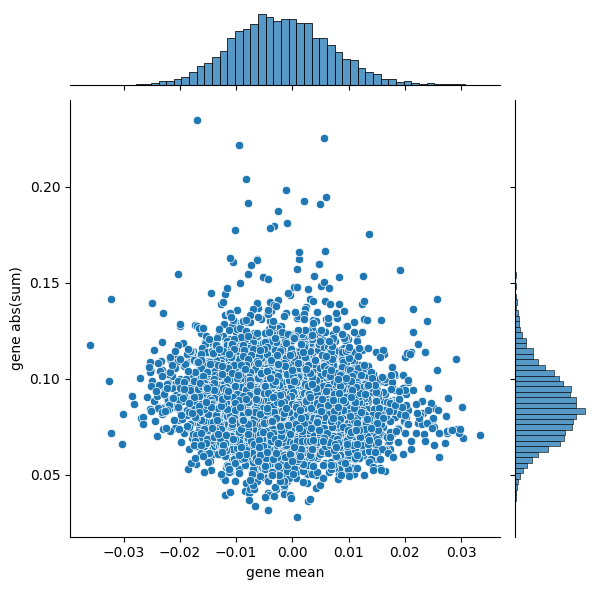

In [23]:
sns.jointplot(x="gene mean", y="gene abs(sum)", kind="scatter", data=gene_summary)

In [24]:
# check which genes are reconstructed very well
gene_summary_sort = gene_summary.sort_values(by="gene abs(sum)", ascending=True)

In [25]:
best_100_genes = list(gene_summary_sort.index[:100])

In [47]:
worst_100_genes = list(gene_summary_sort.index[-100:])

Compute reconstruction losses

In [266]:
BCE_loss = []
KLD_loss = []
MSE_loss = []
# print row vectors next to each other in a loop
for i in range(len(rnaseq_df)):
    x = torch.Tensor(rnaseq_df.iloc[i].values)
    y = torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
    bce_loss = F.binary_cross_entropy(x, y)
    mse_loss = F.mse_loss(x, y)

    # prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
    #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))

    # kld_loss = torch.sum(kl_divergence(x, prior).item())
    BCE_loss.append(bce_loss)
    MSE_loss.append(mse_loss)

Permutation and adding noise

In [267]:
# Each row is shuffled randomly
def shuffle_random_subset_rows(df, subset_size):
    """
    Shuffles a random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    for i in range(len(df_shuffled)):
        subset_cols = np.random.choice(num_cols, subset_size, replace=False)
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(
            df_shuffled.iloc[i, subset_cols]
        )
    return df_shuffled

In [268]:
rnaseq_df.shape[1]

5000

In [269]:
# 1 percent of data shuffeled
rnaseq_df_1_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.01)
)

# 3.0 percent of data shuffeled
rnaseq_df_3_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.05)
)

# 5.0 percent of data shuffeled
rnaseq_df_5_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.10)
)

# 8.0 percent of data shuffeled
rnaseq_df_8_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.30)
)

# 10.0 percent of data shuffeled
rnaseq_df_10_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.50)
)

# 20.0 percent of data shuffeled
rnaseq_df_20_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.80)
)

In [270]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1_rs = model.forward(
    torch.tensor(rnaseq_df_1_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_1_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_1_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3_rs = model.forward(
    torch.tensor(rnaseq_df_3_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_3_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_3_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5_rs = model.forward(
    torch.tensor(rnaseq_df_5_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_5_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_5_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8_rs = model.forward(
    torch.tensor(rnaseq_df_8_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_8_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_8_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10_rs = model.forward(
    torch.tensor(rnaseq_df_10_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_10_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_10_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20_rs = model.forward(
    torch.tensor(rnaseq_df_20_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_20_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_20_rs.detach().numpy(), columns=rnaseq_df.columns
)

In [300]:
# compute losses
def compute_losses(rnaseq_df, input_rnaseq_reconstruct):
    BCE_loss = []
    MSE_loss = []
    KLD_loss = []
    for i in range(len(rnaseq_df)):
        x = torch.Tensor(rnaseq_df.iloc[i].values)
        y = torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
        bce_loss = F.binary_cross_entropy(x, y)
        mse_loss = F.mse_loss(x, y)

        # prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
        #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))

        # kld_loss = torch.sum(kl_divergence(x, prior).item())
        BCE_loss.append(bce_loss.numpy().item())
        MSE_loss.append(mse_loss.numpy().item())

    return BCE_loss, MSE_loss

In [301]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0]))

1.4035129270749611
1.390797559748872
1.3975967218953382
1.4184416728254485
1.4537280795679037
1.7419378519286162


In [302]:
max(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])

0.03877134248614311

In [303]:
# Each row is shuffled identically
import numpy as np
import pandas as pd


def shuffle_same_subset_rows(df, subset_size):
    """
    Shuffles the same random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    subset_cols = np.random.choice(num_cols, subset_size, replace=False)
    for i in range(len(df_shuffled)):
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(
            df_shuffled.iloc[i, subset_cols]
        )
    return df_shuffled

In [304]:
# 1 percent of data shuffeled
rnaseq_df_1_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.01)
)

# 3.0 percent of data shuffeled
rnaseq_df_3_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.05)
)

# 5.0 percent of data shuffeled
rnaseq_df_5_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.10)
)

# 8.0 percent of data shuffeled
rnaseq_df_8_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.30)
)

# 10.0 percent of data shuffeled
rnaseq_df_10_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.50)
)

# 20.0 percent of data shuffeled
rnaseq_df_20_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.80)
)

In [305]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1_ss = model.forward(
    torch.tensor(rnaseq_df_1.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_1_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_1_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3_ss = model.forward(
    torch.tensor(rnaseq_df_3_same_subset.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_3_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_3_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5_ss = model.forward(
    torch.tensor(rnaseq_df_5_same_subset.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_5_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_5_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8_ss = model.forward(
    torch.tensor(rnaseq_df_8_same_subset.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_8_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_8_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10_ss = model.forward(
    torch.tensor(rnaseq_df_10_same_subset.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_10_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_10_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20_ss = model.forward(
    torch.tensor(rnaseq_df_20.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_20_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_20_ss.detach().numpy(), columns=rnaseq_df.columns
)

In [306]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[0]))

1.4035129270749611
1.407702139755052
1.394832855998672
1.4035665566959983
1.4527834381758598
1.74700486665702


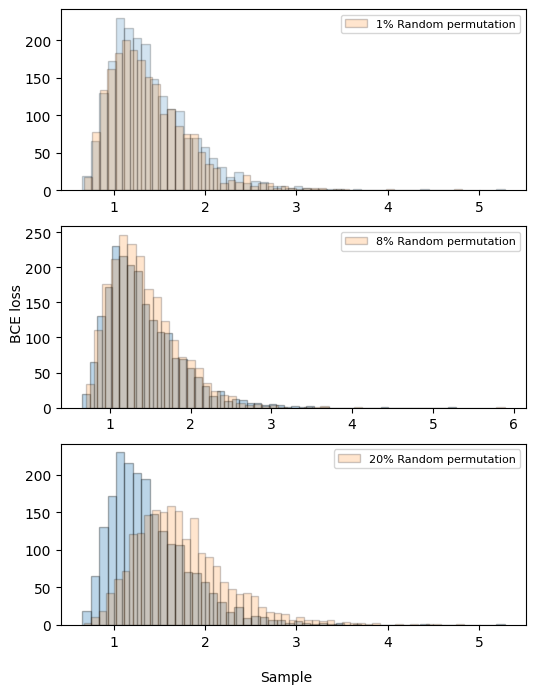

In [307]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="1% Random permutation",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="8% Random permutation",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="20% Random permutation",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "BCE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

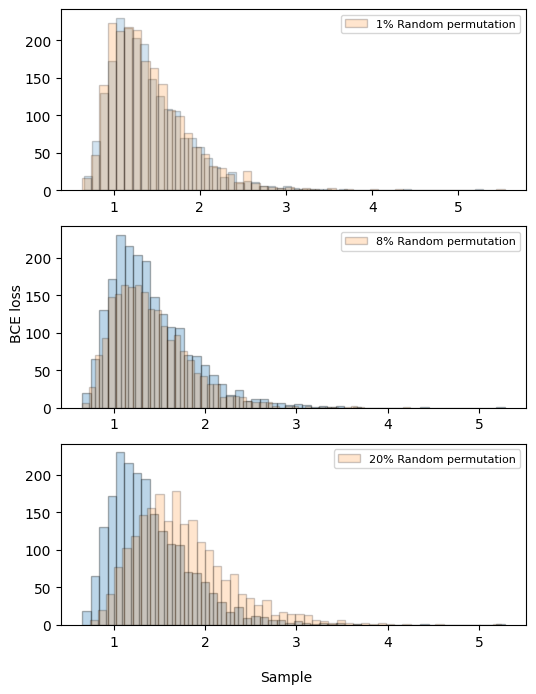

In [308]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="1% Random permutation",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="8% Random permutation",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="20% Random permutation",
)
ax3.legend(fontsize=8)

# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "BCE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

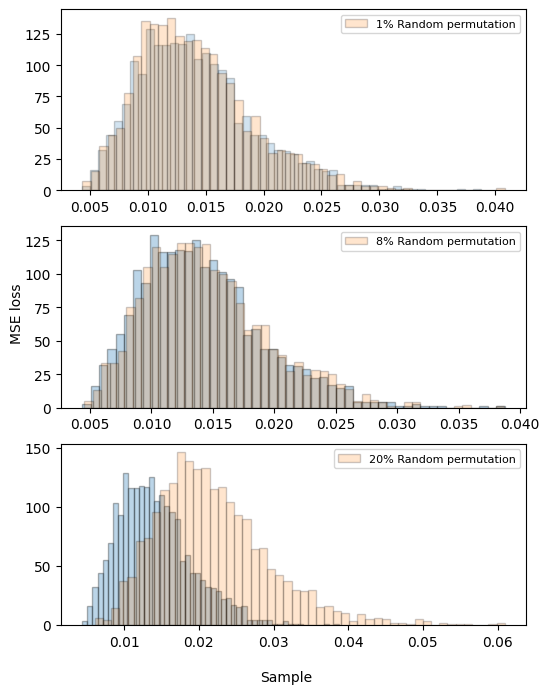

In [309]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="1% Random permutation",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="8% Random permutation",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="20% Random permutation",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "MSE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

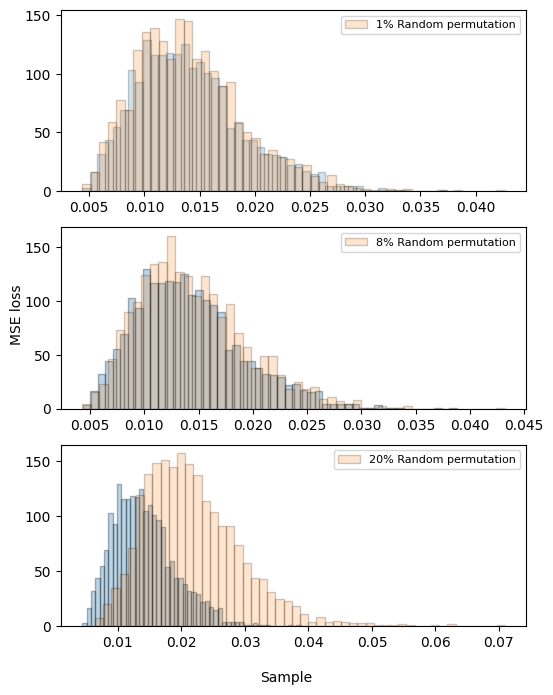

In [310]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="1% Random permutation",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="8% Random permutation",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="20% Random permutation",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "MSE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

Add Gaussian noise to genes

In [311]:
import numpy as np
import pandas as pd


def add_gaussian_noise(dataframe, mean=0, std_dev=1):
    """
    Adds Gaussian noise to each element of a pandas DataFrame.

    Args:
    dataframe: pandas DataFrame to add noise to.
    mean: Mean of the Gaussian distribution (default: 0)
    std_dev: Standard deviation of the Gaussian distribution (default: 1)

    Returns:
    pandas DataFrame with added Gaussian noise
    """
    noisy_dataframe = dataframe.applymap(lambda x: x + np.random.normal(mean, std_dev))
    return noisy_dataframe

In [312]:
rnaseq_df_noisy_0p1 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.1)
rnaseq_df_noisy_0p3 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.3)
rnaseq_df_noisy_0p6 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.6)
rnaseq_df_noisy_0p9 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.9)

In [313]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p1 = model.forward(
    torch.tensor(rnaseq_df_noisy_0p1.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_noisy_0p1 = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_noisy_0p1.detach().numpy(),
    columns=rnaseq_df.columns,
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p3 = model.forward(
    torch.tensor(rnaseq_df_noisy_0p3.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_noisy_0p3 = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_noisy_0p3.detach().numpy(),
    columns=rnaseq_df.columns,
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p6 = model.forward(
    torch.tensor(rnaseq_df_noisy_0p6.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_noisy_0p6 = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_noisy_0p6.detach().numpy(),
    columns=rnaseq_df.columns,
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p9 = model.forward(
    torch.tensor(rnaseq_df_noisy_0p9.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_noisy_0p9 = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_noisy_0p9.detach().numpy(),
    columns=rnaseq_df.columns,
)

In [314]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p3)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0]))

1.4035129270749611
1.4022376792608666
1.4063075713343192
1.466934262196147
1.547133966596587


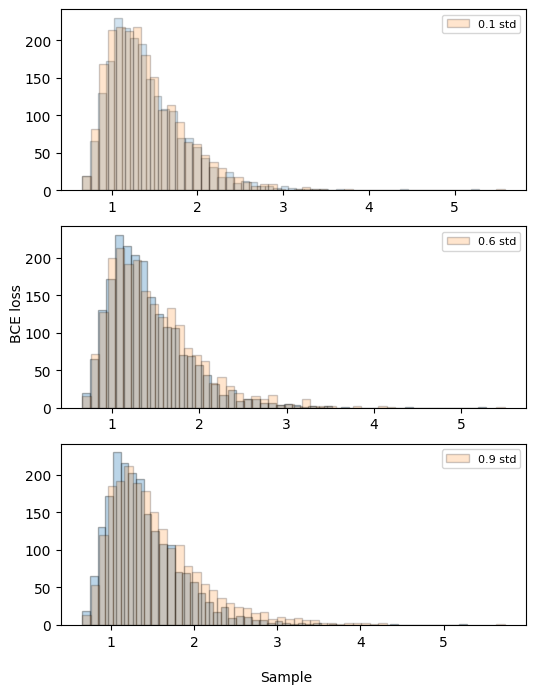

In [315]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.6 std",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.9 std",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "BCE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

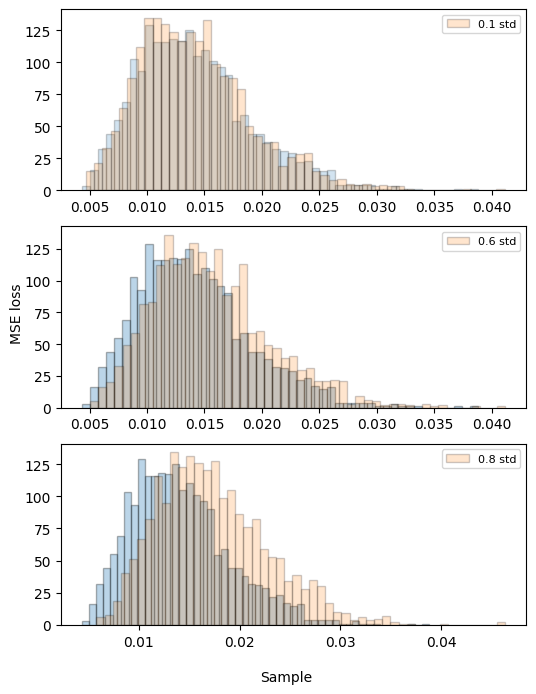

In [316]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.6 std",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.8 std",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "MSE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

Compute mean

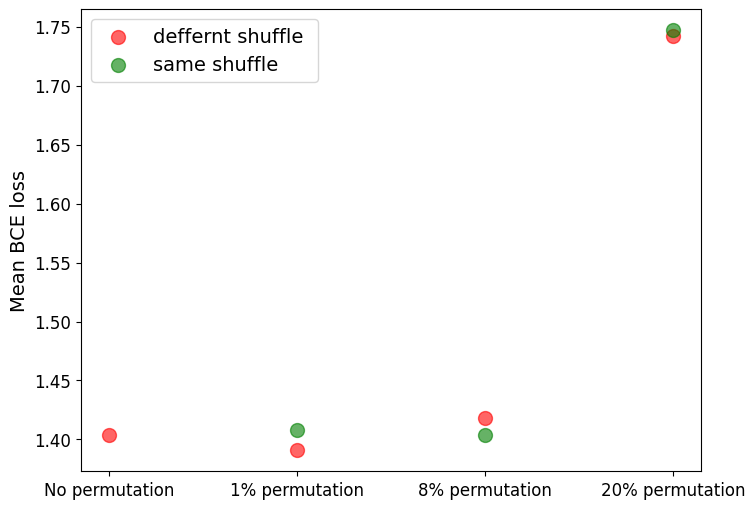

<Figure size 640x480 with 0 Axes>

In [317]:
## compare the performance here
plt.figure(figsize=(8, 6))

plt.scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])],
    c="r",
    s=100,
    alpha=0.6,
    label="deffernt shuffle ",
)
plt.scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0])],
    c="r",
    s=100,
    alpha=0.6,
)


plt.scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[0])],
    c="g",
    s=100,
    alpha=0.6,
    label="same shuffle",
)
plt.scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[0])],
    c="g",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[0])],
    c="g",
    s=100,
    alpha=0.6,
)
plt.legend(fontsize=14)

plt.yticks(fontsize=12)
plt.xticks(
    [0, 1, 2, 3],
    ["No permutation", "1% permutation", "8% permutation", "20% permutation"],
    fontsize=12,
)

plt.ylabel("Mean BCE loss", fontsize=14)
plt.show()
plt.savefig("results/BCE_gene_loss.png")

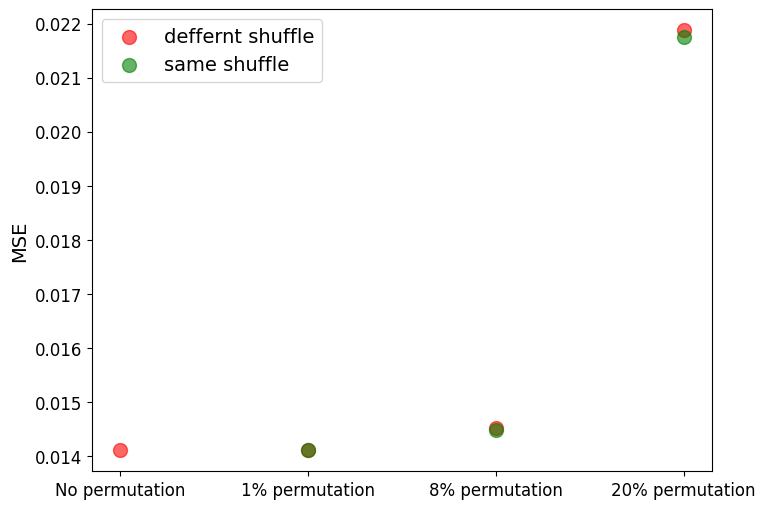

<Figure size 640x480 with 0 Axes>

In [318]:
## compare the performance here
plt.figure(figsize=(8, 6))

plt.scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])],
    c="r",
    s=100,
    alpha=0.6,
    label="deffernt shuffle",
)
plt.scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[1])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1])],
    c="r",
    s=100,
    alpha=0.6,
)


plt.scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[1])],
    c="g",
    s=100,
    alpha=0.6,
    label="same shuffle",
)
plt.scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[1])],
    c="g",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[1])],
    c="g",
    s=100,
    alpha=0.6,
)
plt.legend(fontsize=14)

plt.yticks(fontsize=12)
plt.xticks(
    [0, 1, 2, 3],
    ["No permutation", "1% permutation", "8% permutation", "20% permutation"],
    fontsize=12,
)

plt.ylabel("MSE", fontsize=14)
plt.show()
plt.savefig("results/BCE_gene_loss.png")

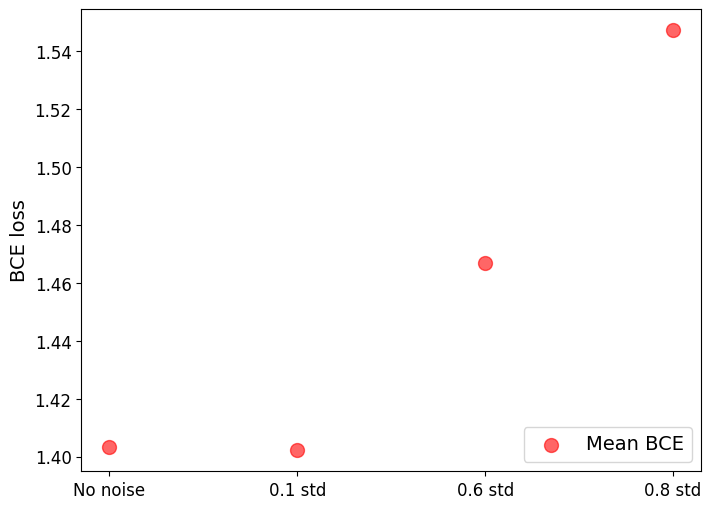

<Figure size 640x480 with 0 Axes>

In [319]:
## compare the performance here
plt.figure(figsize=(8, 6))

plt.scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])],
    c="r",
    s=100,
    alpha=0.6,
    label="Mean BCE",
)
plt.scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0])],
    c="r",
    s=100,
    alpha=0.6,
)


plt.legend(fontsize=14, loc=4)

plt.yticks(fontsize=12)
plt.xticks([0, 1, 2, 3], ["No noise", "0.1 std", "0.6 std", "0.8 std"], fontsize=12)

plt.ylabel("BCE loss", fontsize=14)
plt.show()
plt.savefig("results/BCE_gene_noisy_loss.png")

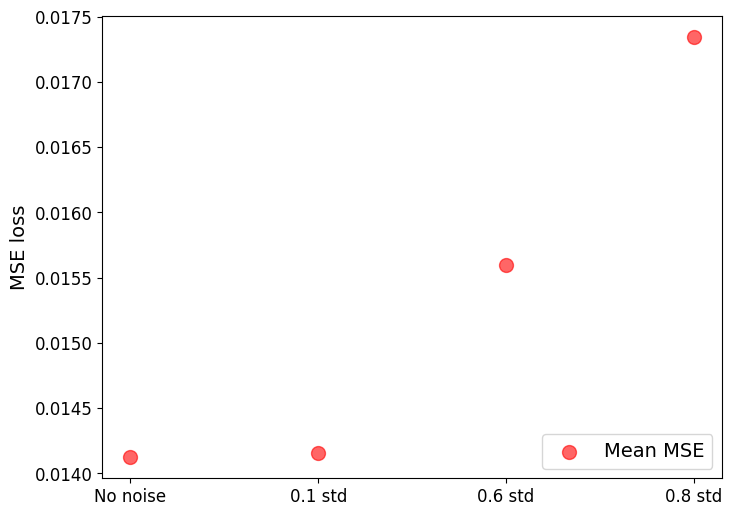

<Figure size 640x480 with 0 Axes>

In [320]:
## compare the performance here
plt.figure(figsize=(8, 6))

plt.scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])],
    c="r",
    s=100,
    alpha=0.6,
    label="Mean MSE",
)
plt.scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[1])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1])],
    c="r",
    s=100,
    alpha=0.6,
)


plt.legend(fontsize=14, loc=4)

plt.yticks(fontsize=12)
plt.xticks([0, 1, 2, 3], ["No noise", "0.1 std", "0.6 std", "0.8 std"], fontsize=12)

plt.ylabel("MSE loss", fontsize=14)
plt.show()
plt.savefig("results/MSE_gene_noisy_loss.png")

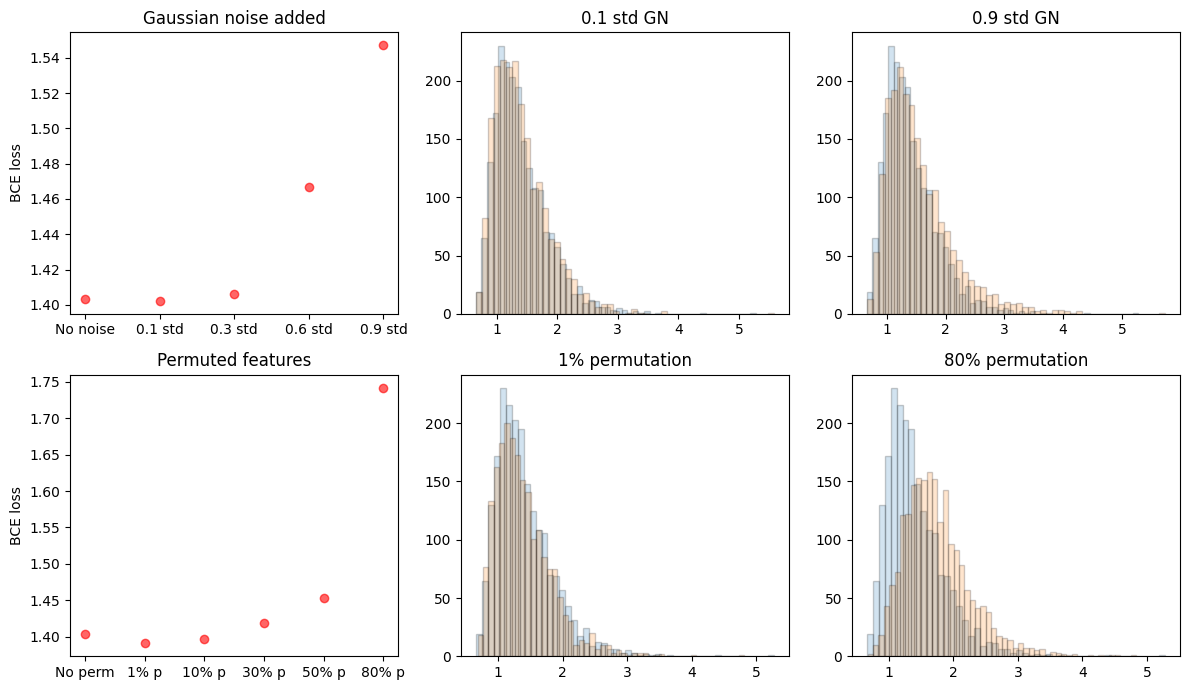

In [321]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

# Plot data on each subplot
axs[0, 0].scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])],
    c="r",
    alpha=0.6,
    label="Mean MSE",
)
axs[0, 0].scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p3)[0])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [4],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0])],
    c="r",
    alpha=0.6,
)

# axs[0, 0].set_ylim(6000, 9000)
axs[0, 0].set_ylabel("BCE loss")
axs[0, 0].set_xticks(
    [0, 1, 2, 3, 4], ["No noise", "0.1 std", "0.3 std", "0.6 std", "0.9 std"]
)
axs[0, 0].set_title("Gaussian noise added")

axs[0, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[0, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)

axs[0, 1].set_title("0.1 std GN")
axs[0, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[0, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
# axs[0, 1].plot(x, y2)
axs[0, 2].set_title("0.9 std GN")
# Plot data on each subplot
axs[1, 0].scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])],
    c="r",
    alpha=0.6,
    label="Mean MSE",
)
axs[1, 0].scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_rs)[0])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [4],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_rs)[0])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [5],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0])],
    c="r",
    alpha=0.6,
)
# axs[1, 0].set_ylim(6000, 9000)

axs[1, 0].set_ylabel("BCE loss")
axs[1, 0].set_title("Permuted features")
axs[1, 0].set_xticks(
    [0, 1, 2, 3, 4, 5], ["No perm", "1% p", "10% p", "30% p", "50% p", "80% p"]
)

axs[1, 1].set_title("1% permutation")
axs[1, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[1, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)

axs[1, 2].set_title("80% permutation")
axs[1, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[1, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
# Set a tight layout
fig.tight_layout()
plt.savefig("data/Mean_BCE_gene_plots.png")
# Display the plots
plt.show()

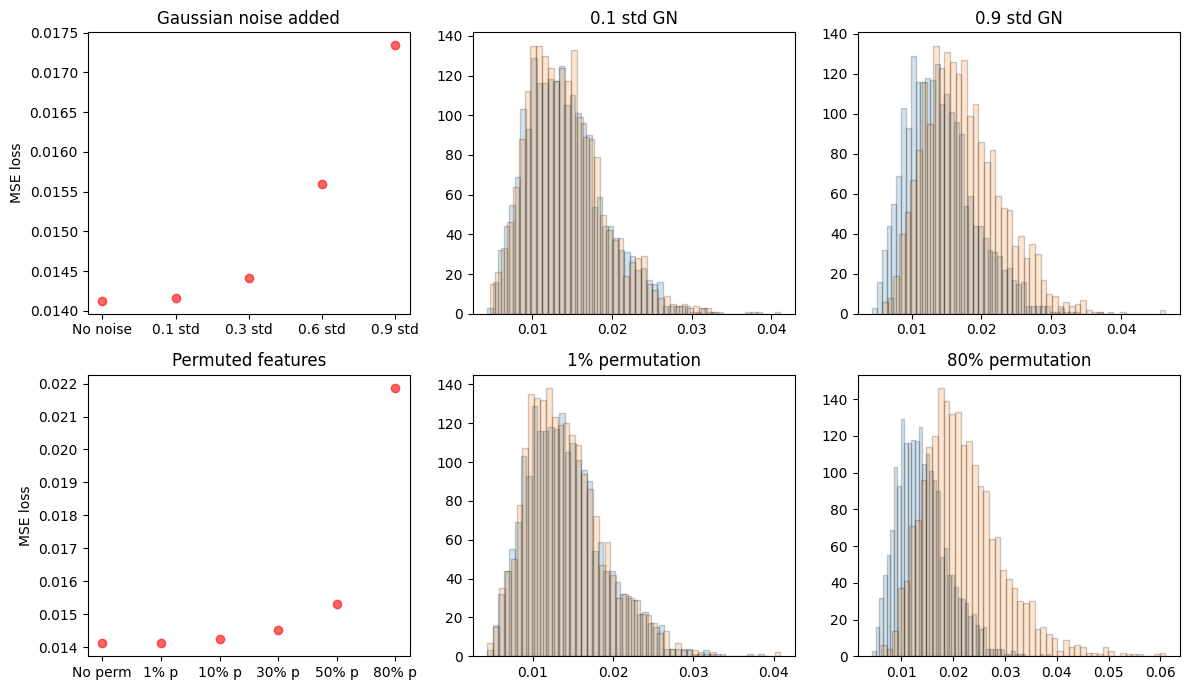

In [322]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

# Plot data on each subplot
axs[0, 0].scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])],
    c="r",
    alpha=0.6,
    label="Mean MSE",
)
axs[0, 0].scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p3)[1])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[1])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [4],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1])],
    c="r",
    alpha=0.6,
)

# axs[0, 0].set_ylim(70, 120)
axs[0, 0].set_ylabel("MSE loss")
axs[0, 0].set_xticks(
    [0, 1, 2, 3, 4], ["No noise", "0.1 std", "0.3 std", "0.6 std", "0.9 std"]
)
axs[0, 0].set_title("Gaussian noise added")

axs[0, 1].set_title("0.1 std GN")
axs[0, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[0, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)

axs[0, 2].set_title("0.9 std GN")
axs[0, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[0, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
# axs[0, 1].plot(x, y2)
# axs[0, 2].set_title("Reconstructed with VAE")
# Plot data on each subplot
axs[1, 0].scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])],
    c="r",
    alpha=0.6,
    label="Mean MSE",
)
axs[1, 0].scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_rs)[1])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[1])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [4],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_rs)[1])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [5],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1])],
    c="r",
    alpha=0.6,
)
# axs[1, 0].set_ylim(70, 120)

axs[1, 0].set_ylabel("MSE loss")
axs[1, 0].set_title("Permuted features")
axs[1, 0].set_xticks(
    [0, 1, 2, 3, 4, 5], ["No perm", "1% p", "10% p", "30% p", "50% p", "80% p"]
)

# axs[1, 1].imshow(permuted_img_tensor.detach().view(1, 28, 28).permute(1, 2, 0))
axs[1, 1].set_title("1% permutation")
axs[1, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[1, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)

axs[1, 2].set_title("80% permutation")
axs[1, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[1, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
# Set a tight layout
# Set a tight layout
fig.tight_layout()
plt.savefig("data/Mean_MSE_gene_plots.png")
# Display the plots
plt.show()

In [323]:
input_rnaseq_reconstruct.max().max()

0.98907906

### Compare models trained with noisy datasets

In [107]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [108]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

In [16]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor = model.forward(
    torch.tensor(rnaseq_df.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct = pd.DataFrame(
    input_rnaseq_reconstruct_tensor.detach().numpy(), columns=rnaseq_df.columns
)

In [17]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_latent_mu = model.forward(
    torch.tensor(rnaseq_df.values, dtype=torch.float32)
)[2]

column_names = [str(i) for i in range(100)]

input_rnaseq_mu = pd.DataFrame(
    input_rnaseq_latent_mu.detach().numpy(), columns=column_names
)

In [18]:
input_rnaseq_mu

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.725187,0.519049,0.114921,-1.878653,-0.628887,-0.732315,-0.986333,-1.059045,0.228296,-1.033898,...,-1.650903,-0.038332,-1.211516,-0.661897,0.291054,-0.255578,-0.566975,-0.164935,0.497684,0.004372
1,0.301664,-0.750930,-0.208181,-0.242019,0.491468,0.216203,-1.385175,-0.865529,-0.971192,-0.972666,...,-0.294495,0.279622,0.968557,-2.317977,0.346017,-0.363222,-0.243847,-0.253952,-1.064087,0.150204
2,-0.294407,-0.203448,-0.845374,-1.260305,0.316481,-0.699027,-1.273635,-0.394184,-0.792353,-0.818484,...,1.093894,-0.898396,-0.713286,-0.874580,-1.022011,0.113929,-0.398466,-0.437810,-0.681952,0.294524
3,-1.529670,-1.284459,-1.161041,-1.756467,-0.029904,-0.057314,0.365484,1.133119,0.124066,-0.825742,...,-0.871278,-1.557278,0.678818,0.158189,-0.219537,0.103417,0.458937,-0.440374,0.580784,-0.868797
4,-0.021663,-0.412536,-1.245847,-2.298170,-0.167209,-0.680066,-0.266624,-0.690219,0.325427,0.021325,...,-1.112234,-0.042224,-1.664874,1.011889,-0.255735,-0.485153,0.591958,0.076155,-0.776677,-0.742260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,-0.406502,-0.956765,-0.468906,-1.707911,0.383328,0.379384,-0.400728,-0.549150,-0.429089,-1.389949,...,-1.137643,-0.604215,-0.916428,-0.127033,-0.503180,-0.650119,-0.670221,0.134646,-0.911241,-0.211693
2088,-1.287970,-0.787130,-0.434002,-0.163710,0.296755,-1.493056,0.189750,0.733074,0.545843,-1.182991,...,-0.796221,-1.114336,-0.083362,-0.499984,-0.721198,-0.681649,0.525709,0.284860,-0.171353,0.801246
2089,-0.365560,-0.362828,-0.122903,-1.097039,0.324071,-0.758484,0.071671,-1.252991,0.739170,-0.106276,...,-0.764694,-0.087117,-0.798534,0.235587,-0.044662,0.230546,-1.054448,-0.150776,-0.860143,-0.765515
2090,-0.485811,0.190297,-1.482424,0.462941,-1.093626,-0.564230,0.508617,0.080528,-0.462929,-0.540377,...,0.636104,-0.656095,-0.384437,-0.665900,-0.222128,-0.242676,0.034940,-0.274873,0.090540,-0.805773


### Results with model trained with noisy data

In [194]:
# load model
def load_trained_model(model, model_name):
    model.load_state_dict(torch.load("../output/models/" + model_name))
    return model


# reconstruct the input dataframe with VAE
def VAE_reconstruct_df(df, model):
    reconstruct_tensor = model.forward(torch.tensor(df.values, dtype=torch.float32))[0]
    dataframe = pd.DataFrame(reconstruct_tensor.detach().numpy(), columns=df.columns)

    return dataframe


# How well does the model reconstruct the input RNAseq data
def VAE_latent_out(df):
    mu = model.forward(torch.tensor(df.values, dtype=torch.float32))[2]
    sigma = model.forward(torch.tensor(df.values, dtype=torch.float32))[3]

    column_names = [str(i) for i in range(100)]

    mu = pd.DataFrame(mu.detach().numpy(), columns=column_names)
    sigma = pd.DataFrame(sigma.detach().numpy(), columns=column_names)

    return mu, sigma


def gene_summary(df, df_reconstruct):
    reconstruction_fidelity = df - df_reconstruct

    gene_mean = reconstruction_fidelity.mean(axis=0)
    gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
    gene_summary = pd.DataFrame(
        [gene_mean, gene_abssum], index=["gene mean", "gene abs(sum)"]
    ).T
    gene_summary = gene_summary.sort_values(by="gene abs(sum)", ascending=True)

    return gene_summary


# plot histograms for the genes which have best recontructions
def plot_histograms_best_genes(df, model):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    df_reconstruct = VAE_reconstruct_df(df, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(df[best_500_genes[70 + i]], bins=100, alpha=0.2)
        ax.hist(df_reconstruct[best_500_genes[70 + i]], bins=100, alpha=0.2)
        ax.set_title(f"gene: {str(best_500_genes[70+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()
    
# plot histograms for the genes which have best recontructions
def plot_histograms_worst_genes(df, model):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    df_reconstruct = VAE_reconstruct_df(df, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    worst_500_genes = list(gene_summary_sort.index[-500:])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(df[worst_500_genes[460+i]], bins=100, alpha=0.2)
        ax.hist(df_reconstruct[worst_500_genes[460+i]], bins=100, alpha=0.2)
        ax.set_title(f"gene: {str(worst_500_genes[460+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

In [195]:
models = os.listdir("../output/models/")
print(models)

['65vae_weights.pth', 'tcga_rnaseq_df_0p20vae_weights.pth', 'tcga_rnaseq_df_0p100vae_weights.pth', 'vae_weights.pth', 'tcga_rnaseq_df_0p40vae_weights.pth', 'tcga_rnaseq_df_0p1vae_weights.pth', 'tcga_rnaseq_df_0p60vae_weights.pth', 'tcga_rnaseq_df_0p80vae_weights.pth']


In [196]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

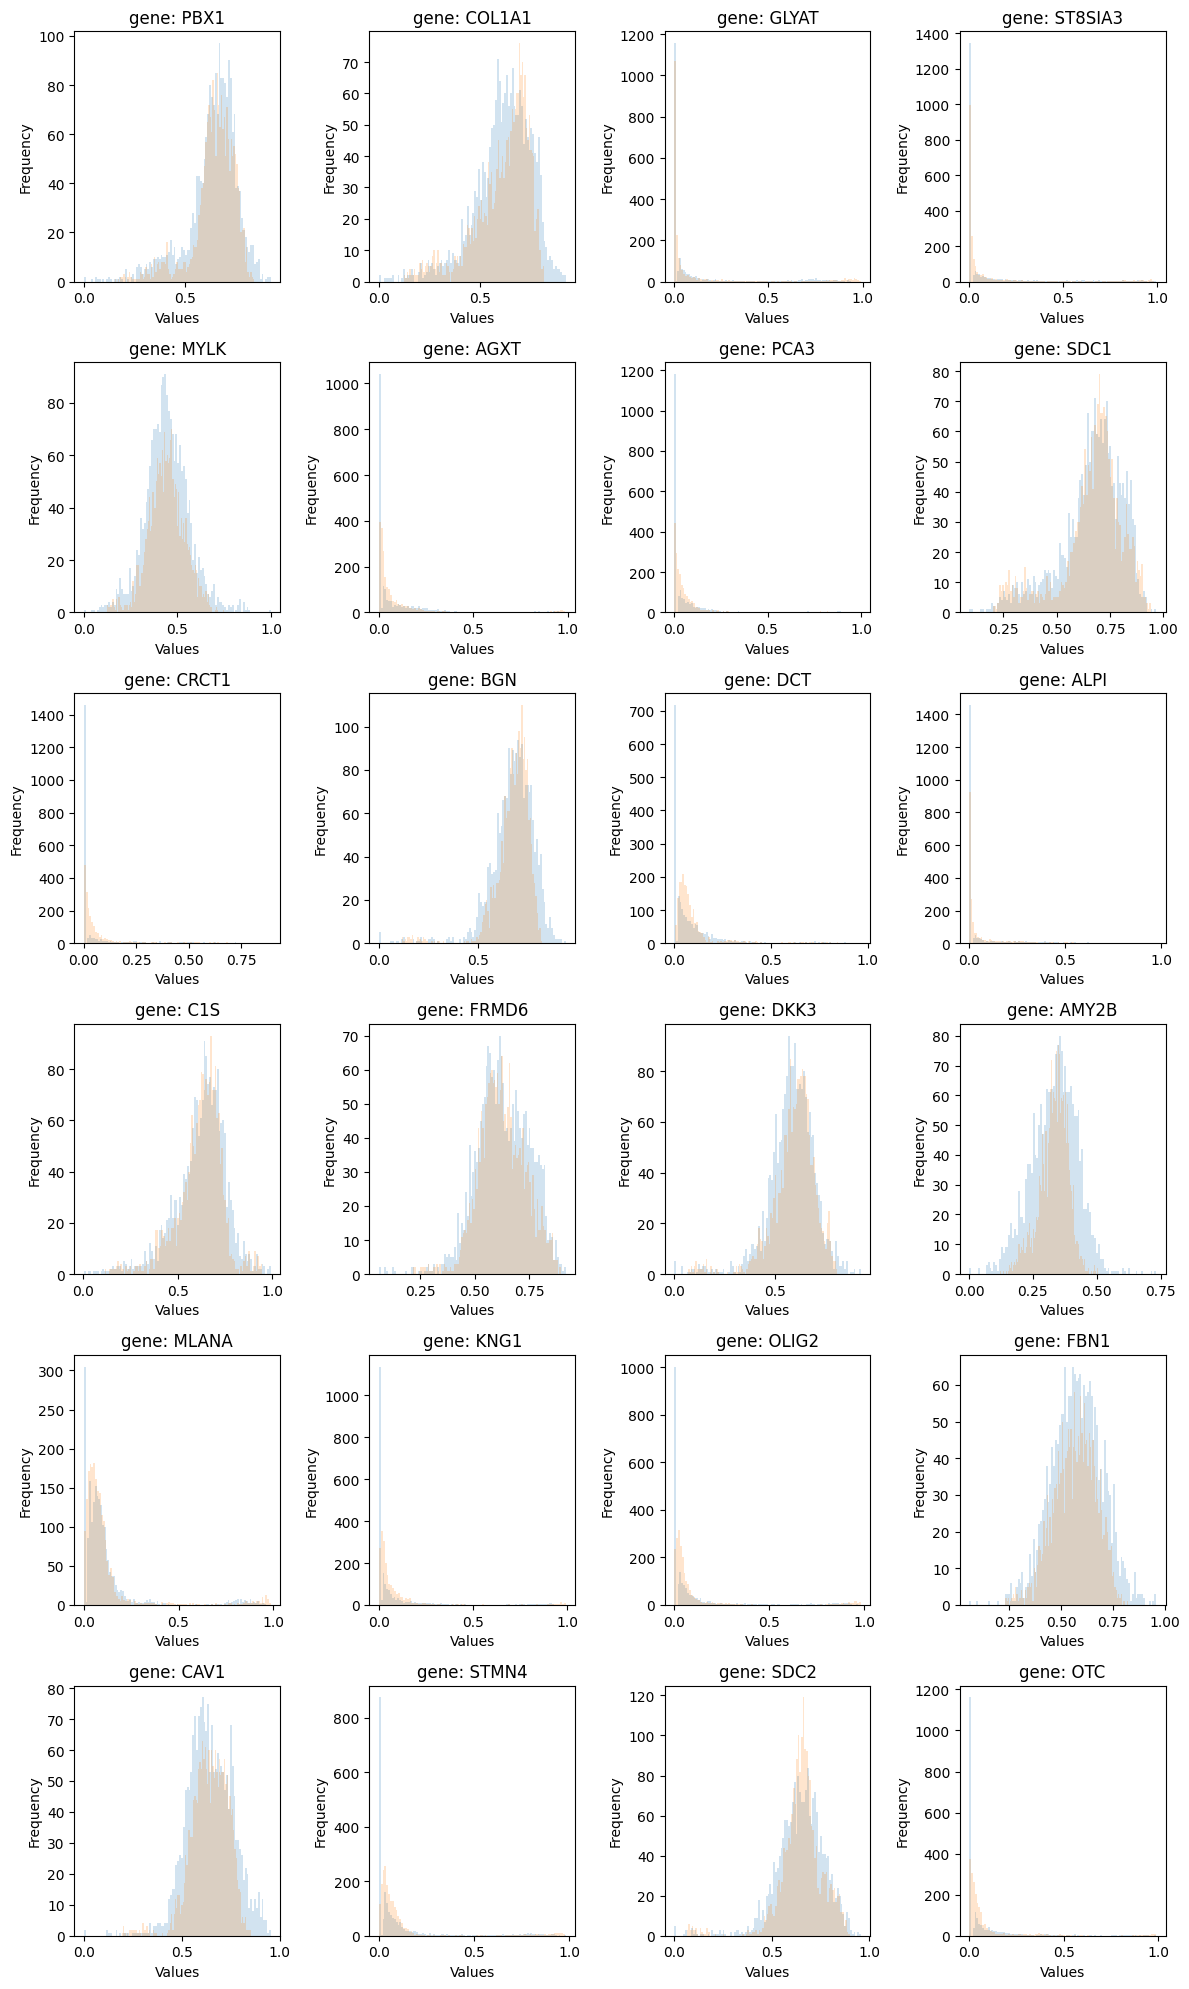

In [197]:
model = load_trained_model(model, model_name=models[-1])
plot_histograms_best_genes(rnaseq_df, model)

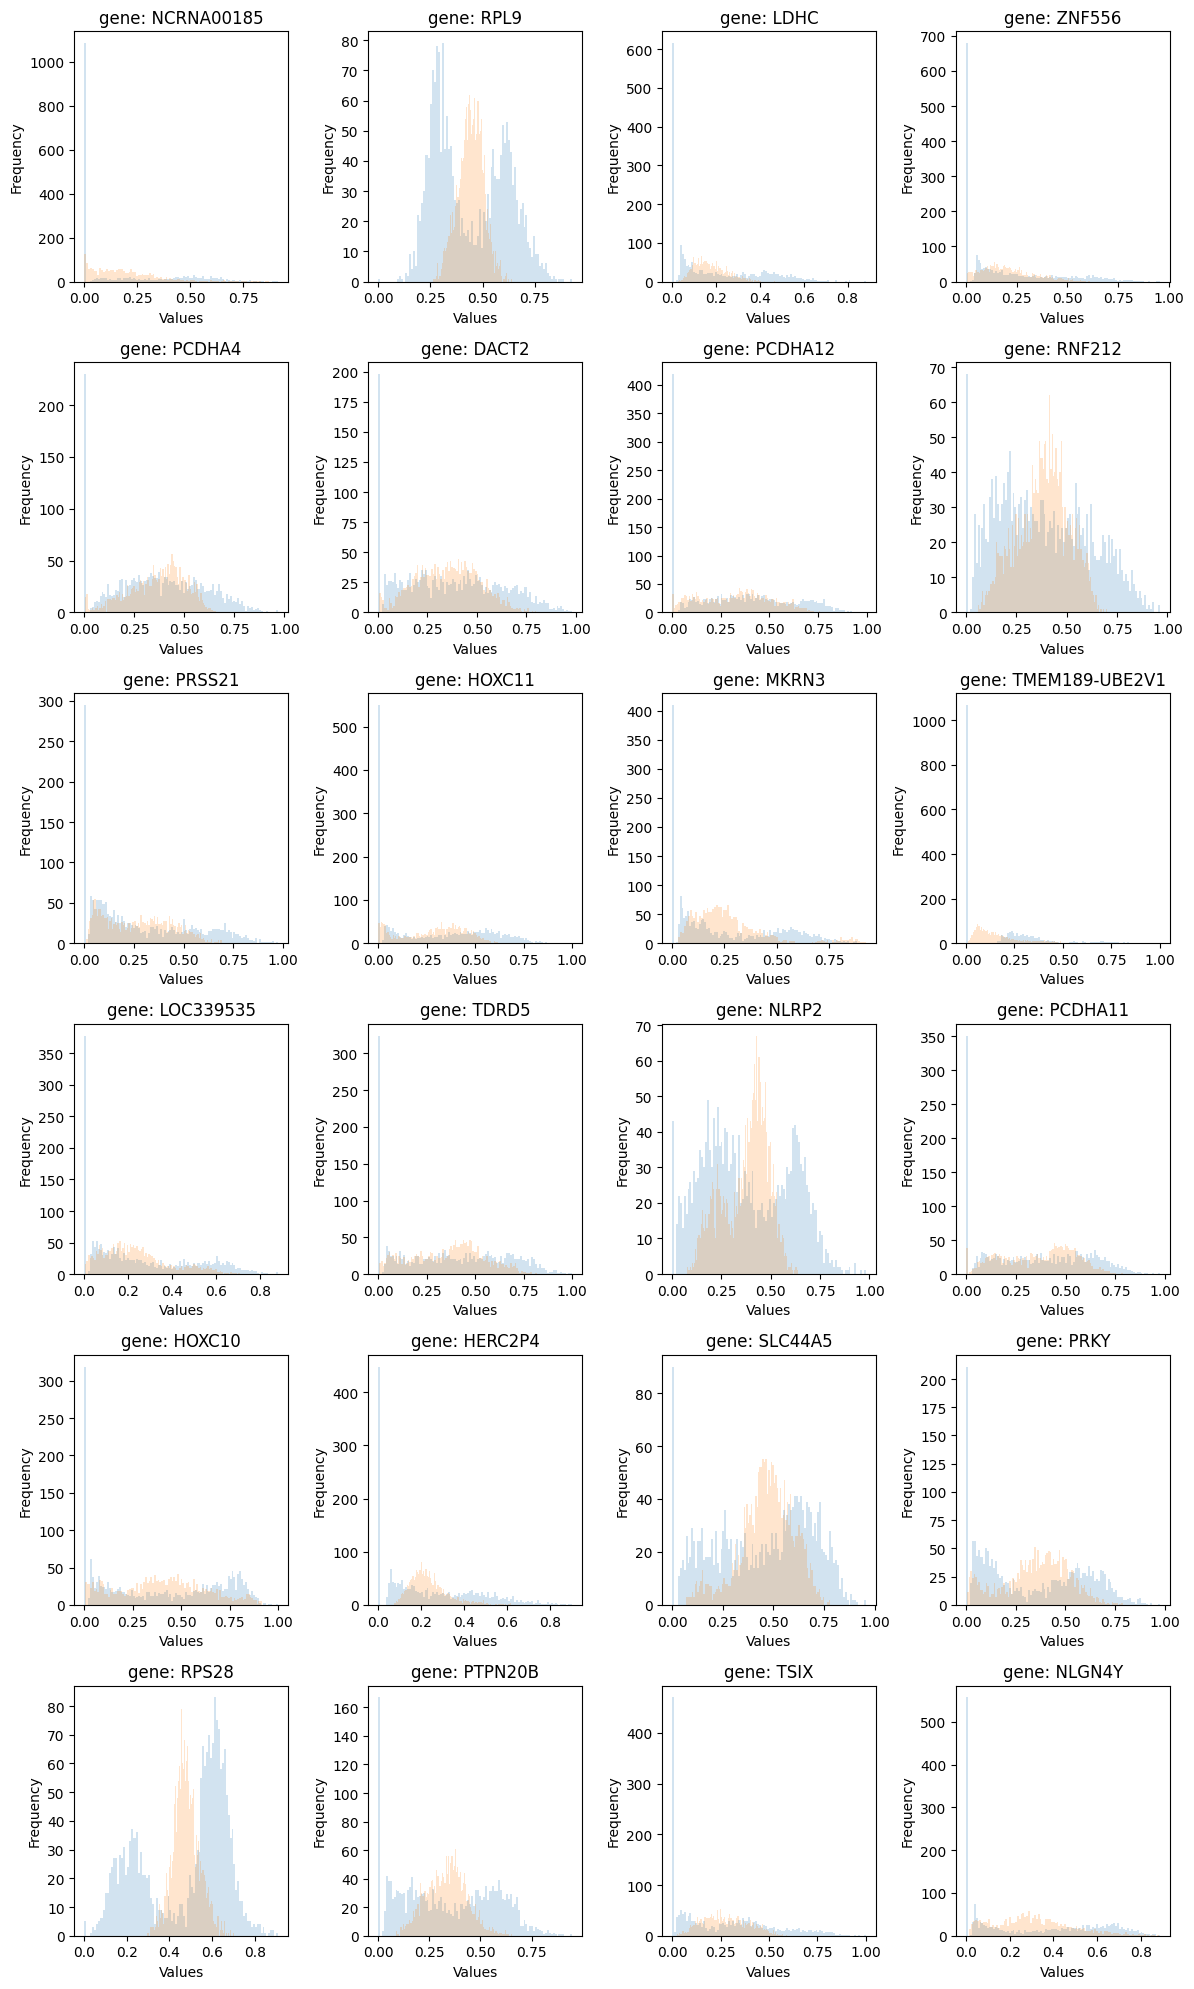

In [198]:
plot_histograms_worst_genes(rnaseq_df, model)